

---


# **Subject : Automatically categorize questions on Stackoverflow**





---











To ask a question un StackOverflow, people need to select some tags in order to maximize their chance to get an answer. In this project, we are volunteer to help StackOverflow by developping an algorithm that will suggest tags based on the title and/or the content of the question.

For doing this, we will need first get some data for training and testing our algorithms. StackOverflow offers a data export tool, "[StackExchange Data Explorer](https://data.stackexchange.com/stackoverflow/query/new)", which lists a large amount of authentic data from the platform.
Therefore you can run the following query in this data export tool to create your dataset and download it:

```
SELECT TOP 10000 Title, Body, Tags, Score, ViewCount, FavoriteCount, AnswerCount, CreationDate
FROM Posts
WHERE ViewCount > 10
AND AnswerCount > 5
AND LEN(Tags) - LEN(REPLACE(Tags, '<','')) <= 4
AND LEN(Tags) - LEN(REPLACE(Tags, '<','')) >= 1
```

If you can't download the data by yourself, you can use the files available in this link : [here](https://1drv.ms/f/c/ab584826bfa6bf60/EmC_pr8mSFgggKuwDgAAAAABUQ7Gb55TD9Sc_u27Dezm2A?e=0Tw5fz)


Below are the steps required to fullful this project :



1.   Process the "Tags" column in order to compute some statistics : wordcloud on the tags, bar diagram with the 20 most common tags
2.   Filter the dataset to keep only rows containing the top 10 tags
3.   Combine the title and the body of the question for the analysis. Apply cleaning process on the corpus (title+body)
4.   Implement an unsupervised approach (LDA for example) to identify main topics/key word on the dataset. Propose some graphics to illustrate the results
5.   Implement a supervised approach to predict the tags (use [this first example](https://www.kaggle.com/discussions/questions-and-answers/66693) to process the target into multiple binary outputs and [this second example](https://dongr0510.medium.com/multi-label-classification-example-with-multioutputclassifier-and-xgboost-in-python-98c84c7d379f) to know how to predicting a multilabel target). Make sure to test and compare the following feature extraction methods :

    *   1 bag-of-word approach : TF-IDF or CountVectorizer
    *   2 word embedding approach among these : Word2Vec, Glove, BERT, USE

  For the word embedding part, you can use [this example of notebook](https://s3.eu-west-1.amazonaws.com/course.oc-static.com/projects/Data_Scientist_P6/Exemple_Tweets_Feature-extraction_Sentence+Embedding_V1.1.ipynb) to help you explore Word2Vec, Doc2Vec, Glove, BERT et USE.

  For the supervised task, test 2 or more models and tune hyperparameters if possible.

6.   Evaluate and compare the models trained after using a train/test split


In [16]:
"""
SELECT TOP 10000 Title, Body, Tags, Score, ViewCount, FavoriteCount, AnswerCount, CreationDate
FROM Posts
WHERE ViewCount > 10
AND AnswerCount > 5
AND LEN(Tags) - LEN(REPLACE(Tags, '<', '')) <= 4
AND LEN(Tags) - LEN(REPLACE(Tags, '<', '')) >= 1
"""

"\nSELECT TOP 10000 Title, Body, Tags, Score, ViewCount, FavoriteCount, AnswerCount, CreationDate\nFROM Posts\nWHERE ViewCount > 10\nAND AnswerCount > 5\nAND LEN(Tags) - LEN(REPLACE(Tags, '<', '')) <= 4\nAND LEN(Tags) - LEN(REPLACE(Tags, '<', '')) >= 1\n"

In [ ]:
# Imports

In [2]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import re
import nltk
from bs4 import BeautifulSoup
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
df = pd.read_csv('QueryResults.csv')

In [4]:
df.head()

,Title,Body,Tags,Score,ViewCount,FavoriteCount,AnswerCount,CreationDate
0,How to override the properties of a CSS class ...,<p>I am fairly new to CSS3 and I want to be ab...,<css><class><overriding>,122,463698,0.0,6,2014-01-06 16:38:24
1,toString() of int e = 0000007 omits all zeros....,<p>I'm trying to write a program in C# that ta...,<c#><numbers><int>,2,668,0.0,9,2010-01-25 08:50:48
2,The fastest way to check if some records in a ...,<p>I have a huge table to work with . I want t...,<database><oracle><hibernate>,10,22104,0.0,6,2010-01-25 09:03:42
3,Can you make valid Makefiles without tab chara...,<pre><code>target: dependencies\n command1\...,<makefile><tabs><whitespace><spaces>,134,70813,0.0,10,2010-01-25 09:15:56
4,CSS - Margins a bad thing?,<p>I've noticed that some browsers have troubl...,<html><css><margin>,5,856,0.0,6,2010-01-25 09:03:52


### 1. **Processing "Tags"**

In [5]:
## Transform tags values into list of tags
def process_tag(s):
  return(list(filter(None, re.split(r'<|>' , s))))

df['tag_list'] =  df.Tags.apply(process_tag)
df[['Tags', 'tag_list']].head()

,Tags,tag_list
0,<css><class><overriding>,"[css, class, overriding]"
1,<c#><numbers><int>,"[c#, numbers, int]"
2,<database><oracle><hibernate>,"[database, oracle, hibernate]"
3,<makefile><tabs><whitespace><spaces>,"[makefile, tabs, whitespace, spaces]"
4,<html><css><margin>,"[html, css, margin]"


In [6]:
# Get list of all tags
l_tags = df.tag_list.apply(lambda x : " ".join(x)).tolist()
all_tags = " ".join(l_tags)
all_tags

'css class overriding c# numbers int database oracle hibernate makefile tabs whitespace spaces html css margin regex comparison formal-languages php mysql passwords encryption python documentation standard-library c# generics dictionary filtering java operators angular angular-cli ios objective-c uiview c# coding-style assert language-agnostic pointers null hex php string arrays casting spring-boot spring-cloud-netflix spring-cloud-config css user-interface sql python django java google-sheets google-sheets-api google-workspace ios swift ios10 html forms lastpass ruby instance-variables private-members java unit-testing homebrew formula wine macos-catalina java soap rest java java arraylist javascript null text macros text-editor forms delphi javascript jquery javascript regex javascript jquery text iphone mkmapview mkannotation java aop python list find indexing php cakephp cakephp-2.4 java equals hashcode language-agnostic design-patterns c# .net regex csv awk sed c# azure azure-keyv

In [7]:
# List of unique tags
unique_tags = np.unique(all_tags.split(' '))
len(unique_tags)

4000

In [8]:
# Count of occurence of tags
(pd.DataFrame(all_tags.split(' '), columns = ['tag'])\
  .groupby('tag').agg({'tag' : 'count'})\
  .rename(columns={'tag': 'count'})\
  .reset_index()\
  .sort_values('count', ascending = False)\
  .head(15))

,tag,count
456,c#,1198
1817,java,968
461,c++,668
2,.net,642
1834,javascript,623
2737,python,591
2576,php,490
3211,sql,367
1596,html,362
235,asp.net,359


In [ ]:
## TODO :=> wordcloud on the tags, bar diagram with the 20 most common tags

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

In [19]:
# Convert tags like "<python><pandas>" into a list ['python', 'pandas']
df['TagList'] = df['Tags'].apply(lambda x: x.strip('<>').split('><'))

# Flatten the list of all tags from all rows
all_tags = [tag for taglist in df['TagList'] for tag in taglist]

tag_counts = Counter(all_tags)
top_tags = tag_counts.most_common(20)

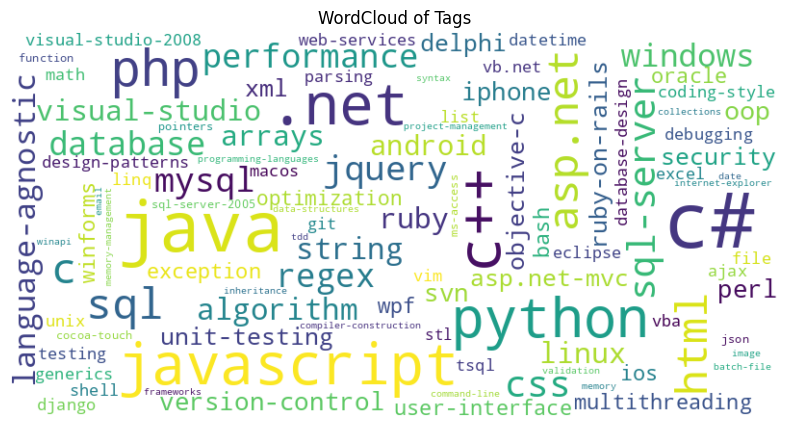

In [67]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Wordcloud
wordcloud = WordCloud(
    max_font_size=80,
    max_words=100,
    background_color="white",
    width=800,
    height=400
).generate_from_frequencies(tag_counts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of Tags")
plt.show()

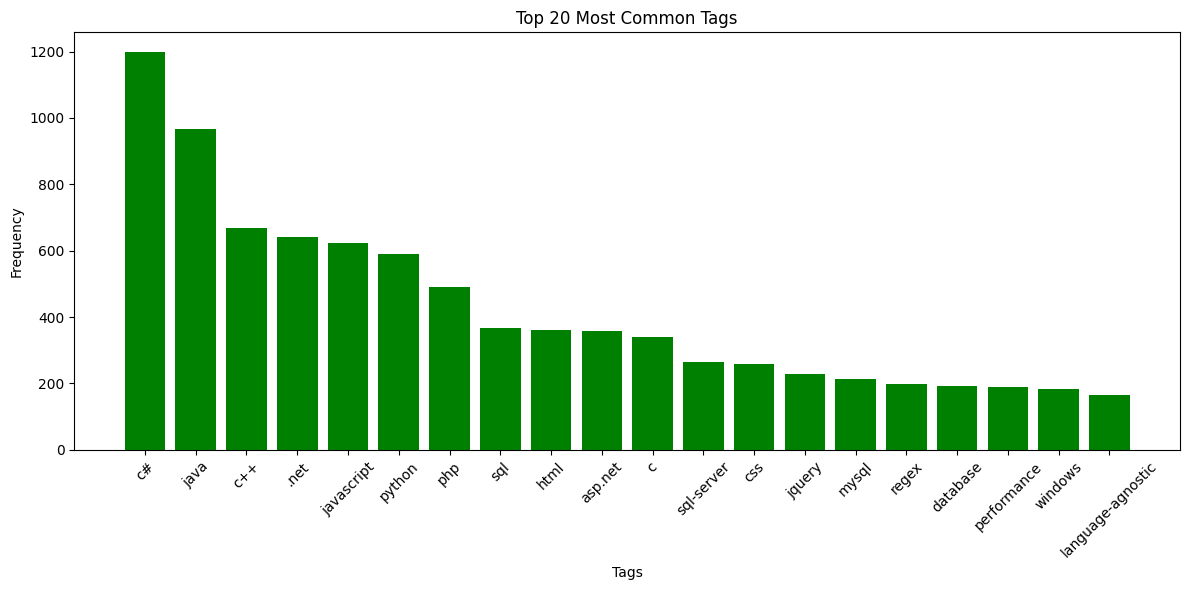

In [65]:
#BarPlot
tags, counts = zip(*top_tags)
plt.figure(figsize=(12, 6))
plt.bar(tags, counts, color = 'green')
plt.xticks(rotation=45)
plt.title("Top 20 Most Common Tags")
plt.xlabel("Tags")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

### 2. **Filter dataset**

In [27]:
## TODO :=> Take the real list of 10 most frequent tags
most_frequent_tags = ["c#", "java", 'c++', '.net', 'javascript', 'python', 'php', 'sql', 'html', 'asp.net']
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

def keep_indicator(l_tags):
  intersect = intersection(l_tags, most_frequent_tags)
  return(int(len(intersect) > 0))

keep_indicator(['tag', "c"])

0

In [30]:
# Create indicator for keeping row or not
df['keep_indicator'] = df['tag_list'].apply(keep_indicator)
df[['tag_list', 'keep_indicator']].head()

,tag_list,keep_indicator
0,"[css, class, overriding]",0
1,"[c#, numbers, int]",1
2,"[database, oracle, hibernate]",0
3,"[makefile, tabs, whitespace, spaces]",0
4,"[html, css, margin]",1


In [31]:
# Clean the tag_list for keeping only selected tags => this cleaned column will be used for modeling
def simplify_tag_list(l):
  return([x for x in l if x in most_frequent_tags])

df['tag_list_final'] = df['tag_list'].apply(simplify_tag_list)
df['n_tags'] = df['tag_list_final'].apply(lambda x : len(x))
df[['tag_list', 'keep_indicator', 'tag_list_final', 'n_tags']].sort_values('n_tags', ascending = False).head(5)

,tag_list,keep_indicator,tag_list_final,n_tags
2547,"[c#, .net, asp.net, javascript]",1,"[c#, .net, asp.net, javascript]",4
874,"[c#, asp.net, javascript]",1,"[c#, asp.net, javascript]",3
3975,"[c#, asp.net, html]",1,"[c#, asp.net, html]",3
9101,"[java, .net, c++, interop]",1,"[java, .net, c++]",3
7311,"[java, .net, javascript]",1,"[java, .net, javascript]",3


In [32]:
## TODO :=> Filter the dataset to keep only rows with selected tags
# Keep only rows with selected tags
df_filtered = df[df['keep_indicator'] == 1]
df_filtered = df_filtered[df_filtered['n_tags'] > 0]

df_filtered[['tag_list_final', 'n_tags']].head()

,tag_list_final,n_tags
1,[c#],1
4,[html],1
6,[php],1
7,[python],1
8,[c#],1


### 3. **Cleaning process**

In [57]:
# TODO :=> complete the cleaning function to add classical cleaning process in NLP (prefer lemmatizing to stemming :)  )
# Concatenate Title & body, then clean
import re
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def remove_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  for data in soup(['style', 'script']):
    data.decompose()
  return ' '.join(soup.stripped_strings)

def clean_text(text):
  s = text.lower() # Lowercase
  s = remove_tags(s) # remove html tags "<.>"
  s = re.sub('\n','', s) # remove line breaks
  s = re.sub(r'(&lt;)|(&gt;)','', s) # remove special sequences
  #... => other cleaning operations
  s = nltk.word_tokenize(s)
  s = [lemmatizer.lemmatize(w) for w in s if w not in stop_words and w.isalpha()]
  s = " ".join(s)
  return s



df['text'] = df[['Title', 'Body']].apply(" ".join, axis=1).apply(clean_text)
df[['Title', 'Body', 'text']].loc[0,:].tolist()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['How to override the properties of a CSS class to avoid copying and renaming styles',
 '<p>I am fairly new to CSS3 and I want to be able to do the following:</p>\n\n<p>When I add a class into a an element, it overrides the properties of another class used in this specific element.</p>\n\n<p>Let\'s say that I have</p>\n\n<pre><code>&lt;a class="left carousel-control" href="#carousel" data-slide="prev"&gt;\n</code></pre>\n\n<p>I want to be able to add a class called <code>bakground-none</code>, that will over override the default background in the class <code>left</code>.</p>\n\n<p>Thanks!</p>\n',
 'override property cs class avoid copying renaming style fairly new want able following add class element override property another class used specific element let say left carousel prev want able add class called override default background class left thanks']

### 4. **Unsupervised approach**

In [63]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt


count_vectorizer = CountVectorizer(stop_words='english', max_df=0.95, min_df=5)
count_data = count_vectorizer.fit_transform(df['text'])

# LDA model
number_topics = 5
lda = LatentDirichletAllocation(n_components=number_topics,
                                random_state=0,
                                n_jobs=1)
lda.fit(count_data)

#Visualization
number_words = 10

def print_topics(model, vectorizer, n_top_words):
    words = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(model.components_):
        print(f"\nTopic #{topic_idx}")
        print(" ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

print_topics(lda, count_vectorizer, number_words)



Topic #0
class int public method code use return new void object

Topic #1
file project code use like application using way version need

Topic #2
table sql number database query select value id like data

Topic #3
user server web page using http like application image way

Topic #4
string value array list function object like return text way


### 5. **Supervised approach**

In [59]:
# TODO :=> apply word embeddings and supervised approaches
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report

#Step 1: TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['text'])

#Step 2: Prepare multilabel targets
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['tag_list_final'])

#Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Step 4: Train classifier
model = OneVsRestClassifier(LogisticRegression(max_iter=1000))
model.fit(X_train, y_train)

#Step 5: Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=mlb.classes_))

              precision    recall  f1-score   support

        .net       0.00      0.00      0.00       129
     asp.net       0.75      0.05      0.10        55
          c#       0.70      0.08      0.15       233
         c++       0.92      0.18      0.29       131
        html       0.79      0.21      0.33        71
        java       0.90      0.40      0.55       197
  javascript       0.93      0.41      0.57       127
         php       0.97      0.35      0.51       100
      python       1.00      0.44      0.62       117
         sql       0.58      0.19      0.29        74

   micro avg       0.88      0.24      0.37      1234
   macro avg       0.75      0.23      0.34      1234
weighted avg       0.76      0.24      0.35      1234
 samples avg       0.14      0.13      0.14      1234



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

### 6. **Evaluation/Comparison**

In [64]:
# TODO :=> Evaluate & compare models
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, accuracy_score, hamming_loss

# Models to compare
models = {
    "Naive Bayes": OneVsRestClassifier(MultinomialNB()),
    "Random Forest": OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
}

# Evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n--- {name} ---")
    print("Hamming Loss:", hamming_loss(y_test, y_pred))
    print("Subset Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=mlb.classes_, zero_division=0))


--- Naive Bayes ---
Hamming Loss: 0.061
Subset Accuracy: 0.479
Classification Report:
              precision    recall  f1-score   support

        .net       0.00      0.00      0.00       129
     asp.net       0.00      0.00      0.00        55
          c#       0.88      0.03      0.06       233
         c++       0.90      0.07      0.13       131
        html       0.33      0.01      0.03        71
        java       1.00      0.02      0.04       197
  javascript       0.50      0.01      0.02       127
         php       0.00      0.00      0.00       100
      python       0.67      0.02      0.03       117
         sql       0.00      0.00      0.00        74

   micro avg       0.71      0.02      0.04      1234
   macro avg       0.43      0.02      0.03      1234
weighted avg       0.55      0.02      0.04      1234
 samples avg       0.01      0.01      0.01      1234


--- Random Forest ---
Hamming Loss: 0.0463
Subset Accuracy: 0.612
Classification Report:
          

Comments: The Random Forest classifier significantly outperformed Naive Bayes across all metrics. Random Forest achieved a lower Hamming Loss (0.046 vs. 0.061) and a notably higher subset accuracy (0.612 vs. 0.479), indicating better overall tag prediction per question. Precision and recall were also considerably higher for most tags, especially frequent ones like php, java, and C++, which Naive Bayes failed to predict effectively. This confirms that Naive Bayes struggles with multilabel tasks and imbalanced classes, while Random Forest handles feature interactions better and provides more reliable results in this context.